<a href="https://colab.research.google.com/github/AditAhmedabadi/Cats_vs_Dogs_DNN_Classifier/blob/master/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Modules

In [1]:
import zipfile
import os
from random import randint
import numpy as np
import pandas as pd
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.7.0


## Downloading Cats and Dogs Dataset

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2022-01-08 14:03:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.181.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   213MB/s    in 0.3s    

2022-01-08 14:03:20 (213 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Extracting Dataset.zip and arranging it

In [3]:
zip_handle = zipfile.ZipFile('/tmp/cats_and_dogs_filtered.zip' , 'r')
zip_handle.extractall('/tmp')
zip_handle.close()

In [4]:
base_dir = "/tmp/cats_and_dogs_filtered"

train_dir = os.path.join(base_dir , 'train')
val_dir = os.path.join(base_dir , 'validation')

cats_train_dir = os.path.join(train_dir , 'cats')
dogs_train_dir = os.path.join(train_dir , 'dogs')

cats_val_dir = os.path.join(val_dir , 'cats')
dogs_val_dir = os.path.join(val_dir , 'dogs')

### Size of Dataset

In [5]:
cats_train_files = os.listdir(cats_train_dir)
dogs_train_files = os.listdir(dogs_train_dir)

cats_val_files = os.listdir(cats_val_dir)
dogs_val_files = os.listdir(dogs_val_dir)

print("Train Images for Cats: {} \nTrain Images for Dogs: {} \nValidation Images for Cats: {} \nValidation Images for Dogs: {}".format(len(cats_train_files),len(dogs_train_files) , len(cats_val_files) , len(dogs_val_files)))

Train Images for Cats: 1000 
Train Images for Dogs: 1000 
Validation Images for Cats: 500 
Validation Images for Dogs: 500


In [6]:
i = randint(0,250)
print(cats_train_files[i:i+7])
print(dogs_train_files[i:i+7])

next_cat_img = [os.path.join(cats_train_dir , img_name) for img_name in cats_train_files[i:i+8]]
next_dog_img = [os.path.join(dogs_train_dir , img_name) for img_name in dogs_train_files[i:i+8]]

['cat.343.jpg', 'cat.864.jpg', 'cat.424.jpg', 'cat.139.jpg', 'cat.209.jpg', 'cat.289.jpg', 'cat.622.jpg']
['dog.556.jpg', 'dog.109.jpg', 'dog.944.jpg', 'dog.227.jpg', 'dog.324.jpg', 'dog.590.jpg', 'dog.629.jpg']


### Printing random images from dataset to get an idea of how the dataset is

(484, 398, 3)
(417, 320, 3)
(223, 499, 3)
(303, 499, 3)
(299, 499, 3)
(240, 155, 3)
(332, 499, 3)
(374, 499, 3)
(374, 500, 3)
(268, 439, 3)
(411, 499, 3)
(499, 444, 3)
(374, 500, 3)
(499, 362, 3)
(332, 499, 3)
(332, 500, 3)


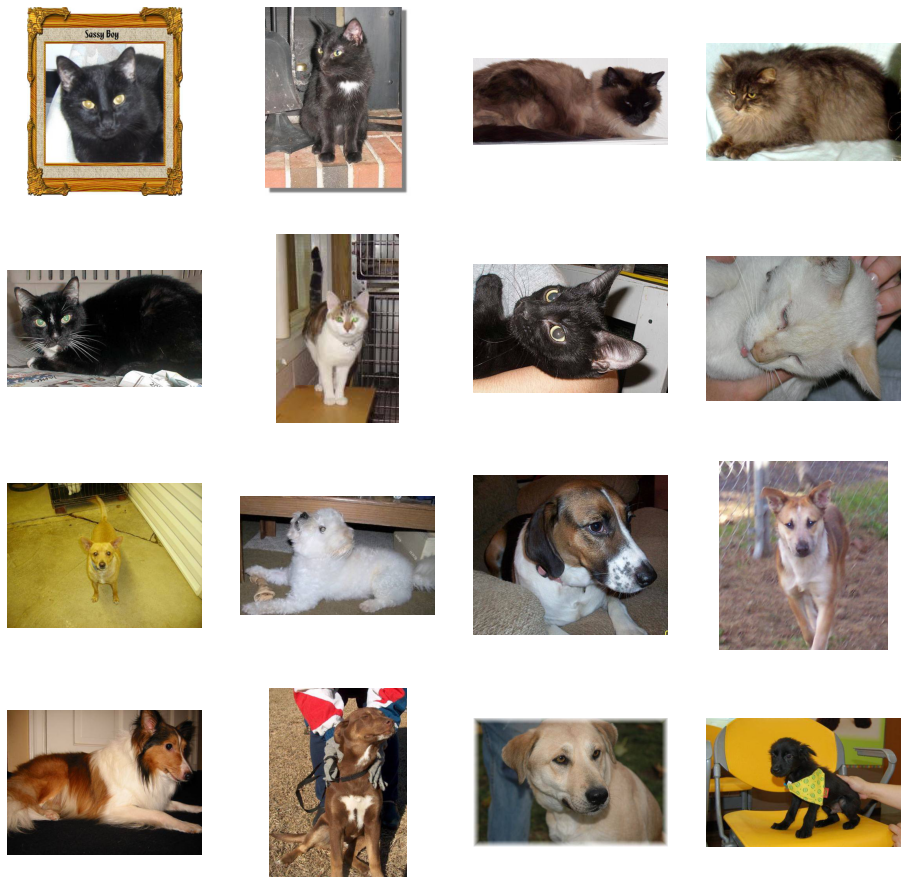

In [7]:
nrows = ncols = 4

fig,ax = plt.subplots(nrows = 4 , ncols = 4)
fig.set_size_inches(16,16)
# for counter , axis in zip(range(0,8) , ax):
img_path = dict(enumerate(next_cat_img + next_dog_img))

count = 0
for m in ax:
  for axis in m:
    image = mpimg.imread(img_path[count])
    axis.imshow(image)
    print(image.shape)
    axis.axis('off')
    count +=1


# Creating the Model

## Implementing ResNet-34 CNN 

### Creating a Custom Identity Block

In [8]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

def identityblock(X, f, filters):
    # Retrieve Filters
    F1, F2, F3 = filters
     
    X_skip = X
    
    # First component
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    
    # Second component
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    # Adding Input
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    
    return X

## Creating a Convolutional Block

In [10]:
def convolution_block(X,f=3,filters = [64,64,64],s=2):
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

## Creating ResNet 50 Architecture

In [13]:
from tensorflow.keras import layers
def resnet50(input_shape = (224,224,3)):
  #Input Layer
  X_input = layers.Input(input_shape)

  #Zero Padding
  X = layers.ZeroPadding2D((3,3))(X_input)

  #First Component
  X = layers.Conv2D(filters = 64,kernel_size=7,strides=2)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D((3,3), strides=2)(X)

  #Second Component
  X = convolution_block(X,3, filters = [64,64,256], s=1)
  X = identityblock(X,3, filters = [64,64,256])
  X = identityblock(X,3, filters = [64,64,256])

  # #Third Compoenent
  X = convolution_block(X,3, filters = [128,128,512])
  X = identityblock(X,3, filters = [128,128,512])
  X = identityblock(X,3, filters = [128,128,512])
  X = identityblock(X,3, filters = [128,128,512])

  #Fourth Component
  X = convolution_block(X,3,filters=[256,256,1024])
  X = identityblock(X,3, filters = [256,256,1024])
  X = identityblock(X,3, filters = [256,256,1024])
  X = identityblock(X,3, filters = [256,256,1024])
  X = identityblock(X,3, filters = [256,256,1024])
  X = identityblock(X,3, filters = [256,256,1024])

  #Fifth Component
  X = convolution_block(X,3, filters = [512,512,2048])
  X = identityblock(X,3, filters = [512,512,2048])
  X = identityblock(X,3, filters = [512,512,2048])

  #2D Average Pooling
  X = layers.AveragePooling2D((2,2), padding = 'same')(X)

  model = tf.keras.models.Model(inputs = X_input,outputs = X)
  return model


In [14]:
base_model = resnet50()

In [15]:
head_model = base_model.output
head_model = Flatten()(head_model)
head_model = Dense(512, activation = 'relu')(head_model)
head_model = Dense(1, activation = 'sigmoid')(head_model)

model = tf.keras.models.Model(inputs = base_model.inputs , outputs = head_model)

In [16]:
weight_file = files.upload()

Saving resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 to resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5


In [17]:
base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [18]:
for layer in base_model.layers:
  layer.Trainable = False

## Brief Description of the process which every image will go through in the Neural Network

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

Using RMSprop optmizer with a learning_rate of 0.001 and binary_crossentropy loss function

In [20]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.1) , loss = 'binary_crossentropy' , metrics = ['accuracy']  )

#Preprocessing Images

By using the ImageDataGenerator in keras.preprocssing.image in keras API.
Here I have used Image Augmentation for better accuracy , the parameters are specified below. Creating a training generator of 150x150 images with batch size of 20

Using Image Augmentation solves the problem of overfitting your data

In [22]:
from tensorflow.keras.applications.resnet50 import preprocess_input
train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = 'sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),
    class_mode = 'sparse'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Fitting Data into the Neural Network
Fitting data with 15 epochs

In [25]:
model_fit = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=30,
                    )

Epoch 1/30
63/63 [==============================] - 64s 897ms/step - loss: 0.1728 - accuracy: 0.9430 - val_loss: 0.1589 - val_accuracy: 0.9540
Epoch 2/30
63/63 [==============================] - 53s 837ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0707 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 53s 838ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9870
Epoch 4/30
63/63 [==============================] - 53s 836ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0405 - val_accuracy: 0.9850
Epoch 5/30
63/63 [==============================] - 53s 836ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.9870
Epoch 6/30
63/63 [==============================] - 53s 838ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0450 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 53s 837ms/step - loss: 6.3074e-04 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.

# Testing Dataset with random cat and dog images picked out from the Internet

Model Predicts each and every photo correctly


Saving dog_test_1.jpg to dog_test_1 (1).jpg


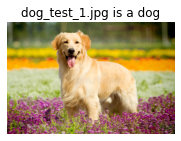

In [27]:
from keras.preprocessing.image import load_img , img_to_array
upload_img = files.upload()

for file_name in upload_img.keys():
  dir = '/content/' + file_name

  inp = load_img(dir,target_size=(224,224))
  inp = img_to_array(inp)

  arr_image = np.expand_dims(inp , axis = 0)
  arr_image = np.vstack([arr_image])

  result = model.predict(arr_image)

  plt.figure(figsize = (3,3))
  axis = plt.gca()
  axis.axis('off')
  if result[0] ==1: 
    plt.title('{} is a dog'.format(file_name))
  else:
    plt.title(('{} is a cat'.format(file_name)))
  img_predict = mpimg.imread(dir)
  plt.imshow(img_predict)



## Plotting the Accuracy - Validation Accuracy Curve and Loss - Validation Loss Curve of the Model Neural Network

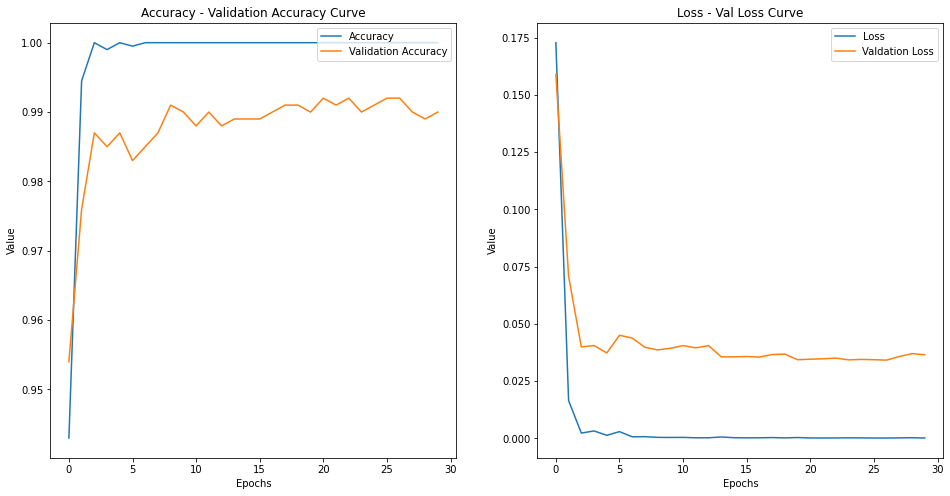

In [29]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']

epochs = range(len(acc))
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,8)
ax[0].plot(epochs , acc , epochs , val_acc)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Value")
ax[0].title.set_text("Accuracy - Validation Accuracy Curve")
ax[0].legend(['Accuracy' , 'Validation Accuracy'] , loc = 'upper right')

ax[1].plot(epochs , loss,  epochs , val_loss ,label = 'Validation Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Value")
ax[1].title.set_text("Loss - Val Loss Curve")
ax[1].legend(['Loss' , 'Valdation Loss'] , loc = 'upper right')
plt.show()

As you can see image augmentation helped in steady growth of both accuracy and validation accuracy and helped the model avoid overfitting
